In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [3]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [31]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)

print(latitude)

[51.47 43.83 53.55 53.75 64.3  69.1  80.   68.3  63.75 48.53 82.52 51.27
 58.47 53.97 74.72 43.93 60.02 68.78 58.1  65.28 58.83 58.75 53.32 50.68
 50.22 53.9  35.05 45.45 57.75 40.35 58.68 40.17 42.75 35.23 61.17 55.03
 45.07 32.5  60.78 46.77 33.57 36.13 43.57 25.9  71.3  42.93 35.97 46.87
 55.2  41.66 32.9  27.77 37.77 39.86 29.37 32.17 39.78 29.37 42.7  41.62
 31.87 24.55 64.82 33.37 35.23 38.95 32.79 48.22 39.13 44.48 36.08 43.89
 38.95 39.43 40.15 48.57 19.72 32.32 30.5  18.43 10.58 41.13 30.12 34.73
 40.87 34.83 31.95 19.43 25.75 42.37 34.78 25.82 44.83 23.18 27.7  30.23
 32.85 24.57 33.02 37.73 41.32 35.4  40.87 64.5  47.7  66.87 35.22 40.67
 40.5  44.05 39.57 43.07 43.23 37.2   9.98 18.43 37.23 32.47 30.25 40.78
 44.92 57.16 27.7  47.46 30.4  39.07 32.12 47.95 44.07 36.05 37.93 32.37
 59.52 46.38 60.72]


In [79]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
print(x_g.shape) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
(28, 22)


[[-133.43494882 -132.34593704 -131.37507097 -130.50459077 -129.72003854
  -129.0095446  -128.36328608 -127.77307281 -127.23202767 -126.73433789
  -126.27505982 -125.84996452 -125.45541472 -125.08826601 -124.74578696
  -124.42559415 -124.12559896 -123.84396375 -123.57906552 -123.32946575
  -123.09388505 -122.87118194]
 [-129.90311085 -129.00281926 -128.20327617 -127.4887314  -126.84650577
  -126.26628853 -125.73961622 -125.25948165 -124.8200369  -124.41636549
  -124.04430565 -123.70031202 -123.38134653 -123.08479135 -122.80837918
  -122.55013681 -122.30833921 -122.08147191 -121.86819997 -121.66734227
  -121.47785008 -121.29878908]
 [-126.25162211 -125.55961481 -124.94698794 -124.40094266 -123.91126898
  -123.46972767 -123.06959997 -122.7053545  -122.37239754 -122.06688348
  -121.78556918 -121.52570098 -121.28492608 -121.06122241 -120.85284273
  -120.6582696  -120.47617894 -120.30541024 -120.14494215 -119.99387228
  -119.8514004  -119.71681442]
 [-122.50526775 -122.03759533 -121.62454299

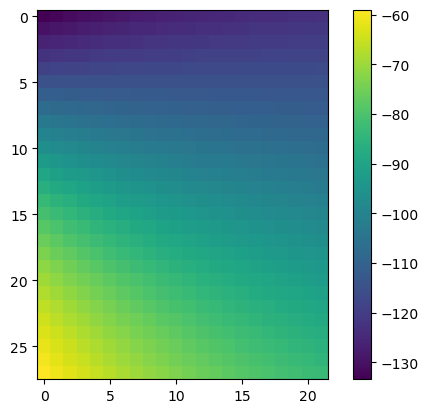

In [107]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
x_g_m = x_g/100
y_g_m = y_g/100
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
print(lamda)

print(psi,lamda)
plt.imshow(lamda)
plt.colorbar()

In [126]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#Getting the mean for each grid point based on radius around 
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
x_ob = x_ob * map_scale
y_ob = y_ob * map_scale

within_roi10 = np.zeros(x_g_m.shape)
roi10 = .10 #in m
roi20 = .20 #in m 
print(within_roi10.shape)
list1 = []
for i in range(len(x_g_m)):
    for j in range(len(x_g_m[i])):
        distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
        # print(distance_analysis_to_ob)
        within_roi10[i,j] = np.count_nonzero(distance_analysis_to_ob<=roi10)
        x_dist = x_g_m[i,j] - x_ob
        y_dist = y_g_m[i,j] - y_ob
        xk = x_dist[np.where(distance_analysis_to_ob<=roi10)]
        yk = y_dist[np.where(distance_analysis_to_ob<=roi10)]
        z = g_h[np.where(distance_analysis_to_ob<=roi10)]
        Dictionary = {"i":i, "j":j, "xk": xk, "yk": yk, "z": z}
        list1.append(Dictionary)

print(len(list1))

#oh shit here we go
xbar = []
ybar = []
xxbar = []
yybar = []
xybar = []
xxxbar = []
xyybar = []
xxybar = []
yyybar = []
xxxxbar = []
xxyybar = []
xxxybar = []
yyyybar = []
xyyybar = []
zbar = []
xzbar = []
yzbar = []
xxzbar = []
yyzbar = []
xyzbar = []

for i in range(len(list1)):
    xbar.append(np.mean(list1[i]["xk"]))
    ybar.append(np.mean(list1[i]["yk"]))
    xxbar.append(np.mean(list1[i]["xk"]**2))
    yybar.append(np.mean(list1[i]["yk"]**2))
    xybar.append(np.mean(list1[i]["xk"]*list1[i]["yk"]))
    xxxbar.append(np.mean(list1[i]["xk"]**3))
    xyybar.append(np.mean(list1[i]["xk"]*list1[i]["yk"]**2))
    xxybar.append(np.mean(list1[i]["xk"]**2*list1[i]["yk"]))
    yyybar.append(np.mean(list1[i]["yk"]**3))
    xxxxbar.append(np.mean(list1[i]["xk"]**4))
    xxyybar.append(np.mean(list1[i]["xk"]**2*list1[i]["yk"]**2))
    xxxybar.append(np.mean(list1[i]["xk"]**3*list1[i]["yk"]))
    yyyybar.append(np.mean(list1[i]["yk"]**4))
    xyyybar.append(np.mean(list1[i]["xk"]*list1[i]["yk"]**3))
    zbar.append(np.mean(list1[i]["z"]))
    xzbar.append(np.mean(list1[i]["xk"]*list1[i]["z"]))
    yzbar.append(np.mean(list1[i]["yk"]*list1[i]["z"]))
    xxzbar.append(np.mean(list1[i]["xk"]**2*list1[i]["z"]))
    yyzbar.append(np.mean(list1[i]["yk"]**2*list1[i]["z"]))
    xyzbar.append(np.mean(list1[i]["xk"]*list1[i]["yk"]*list1[i]["z"]))

xbar = np.array(xbar).reshape(28,22)
ybar = np.array(ybar).reshape(28,22)
xxbar = np.array(xxbar).reshape(28,22)
yybar = np.array(yybar).reshape(28,22)
xybar = np.array(xybar).reshape(28,22)
xxxbar = np.array(xxxbar).reshape(28,22)
xyybar = np.array(xyybar).reshape(28,22)
xxybar = np.array(xxybar).reshape(28,22)
yyybar = np.array(yyybar).reshape(28,22)
xxxxbar = np.array(xxxxbar).reshape(28,22)
xxyybar = np.array(xxyybar).reshape(28,22)
xxxybar = np.array(xxxybar).reshape(28,22)
yyyybar = np.array(yyyybar).reshape(28,22)
xyyybar = np.array(xyyybar).reshape(28,22)
zbar = np.array(zbar).reshape(28,22)
xzbar = np.array(xzbar).reshape(28,22)
yzbar = np.array(yzbar).reshape(28,22)
xxzbar = np.array(xxzbar).reshape(28,22)
yyzbar = np.array(yyzbar).reshape(28,22)
xyzbar = np.array(xyzbar).reshape(28,22)


inverted = np.array([[np.ones_like(x_g), xbar, ybar, xxbar, yybar, xybar]
[xbar, xxbar, xybar, xxxbar, xybar, xxybar]
[ybar, xybar, yybar, xxybar, yyybar, xyybar]
[xxbar, xxxbar, xxybar, xxxxbar, xxyybar, xxxbar]
[yybar, xyybar, yyybar, xxyybar, yyyybar, xyyybar]
[xybar, xxybar, xyybar, xxxybar, xyyybar, xyybar]])
print(inverted)

matrix = np.array([[np.ones_like(x_g), zbar, xzbar, yzbar, xxzbar, yyzbar, xyzbar]])

coefficients = matrix * np.linalg.inv(inverted)


# list2 = []
# within_roi20 = np.zeros(x_g_m.shape)
# for i in range(len(x_g_m)):
#     for j in range(len(x_g_m[i])):
#         distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
#         # print(distance_analysis_to_ob)
#         within_roi20[i,j] = np.count_nonzero(distance_analysis_to_ob<=roi20)
#         x_dist = x_g_m[i,j] - x_ob
#         y_dist = y_g_m[i,j] - y_ob
#         xk = x_dist[np.where(distance_analysis_to_ob<=roi20)]
#         yk = y_dist[np.where(distance_analysis_to_ob<=roi20)]
#         Dictionary = {"i":i, "j":j, "xk": xk, "yk": yk}
#         list2.append(Dictionary)
        

(28, 22)
616


<>:98: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:98: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_2668/2920787504.py:98: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  inverted = np.array([[np.ones_like(x_g), xbar, ybar, xxbar, yybar, xybar]
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_2668/2920787504.py:98: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  inverted = np.array([[np.ones_like(x_g), xbar, ybar, xxbar, yybar, xybar]
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_2668/2920787504.py:98: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  inverted = np.array([[np.ones_like(x_g), xbar, ybar, xxbar, yybar, xybar]
/var/folders/ph/gnz9scgj5491zgp3rggx7

TypeError: list indices must be integers or slices, not tuple

In [ ]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,ANALYSIS[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


/Users/techadmin/mambaforge/envs/atsc528/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/techadmin/mambaforge/envs/atsc528/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


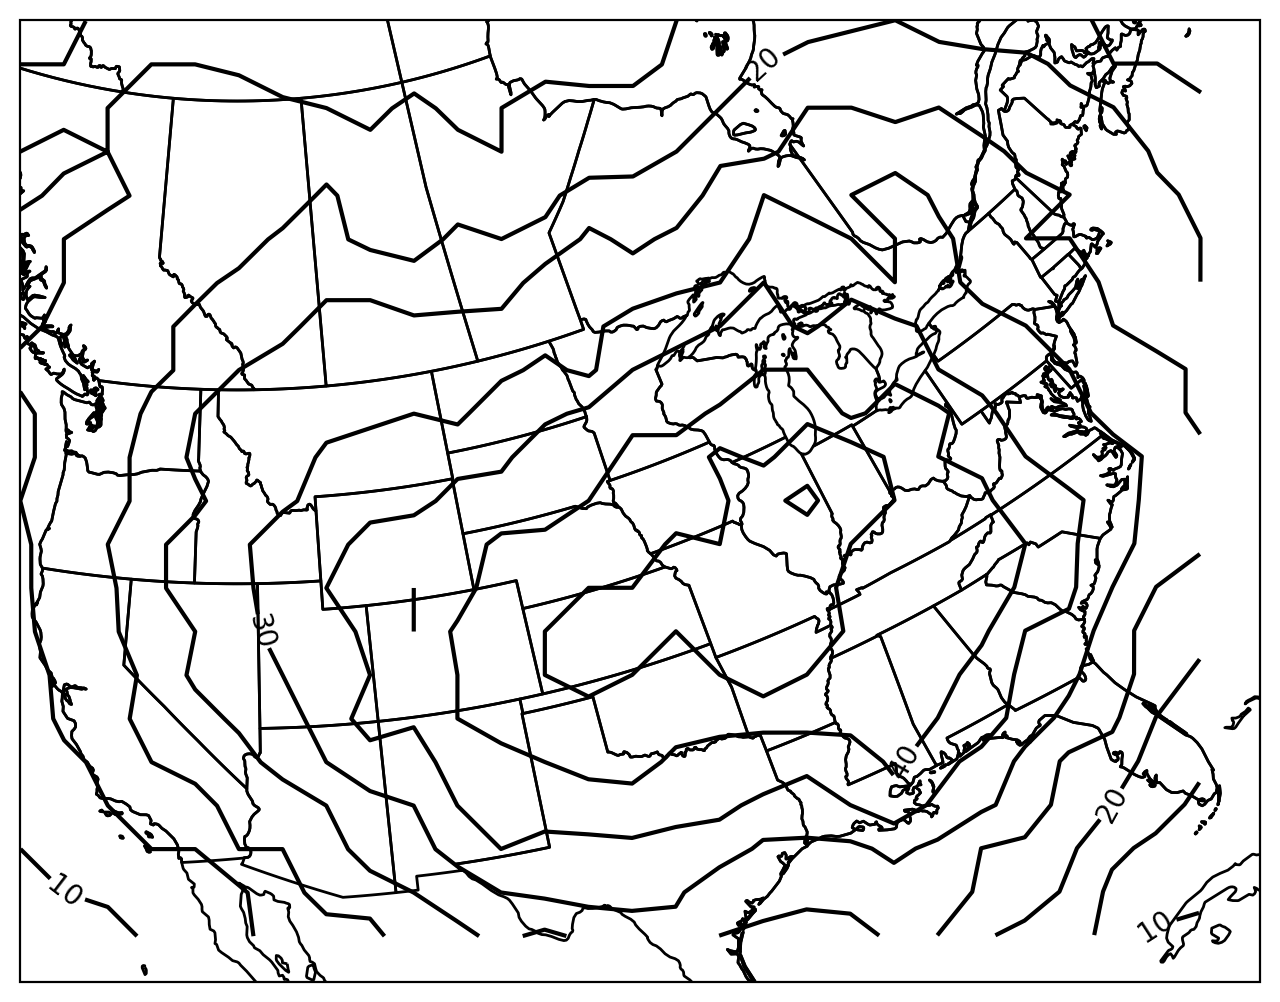

In [109]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,within_roi10,colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.show()

In [ ]:
### Store the analyses in text files ###



In [ ]:
### Store the number of observations available for each grid point in text files ###



In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    

'''